# FINAL PROJECT

## Restuarany Density within City

### Import All Libraries

In [1]:
import folium
from geopy.geocoders import Nominatim
from geopy.distance import distance
import urllib.request
from zipfile import ZipFile
from uszipcode import SearchEngine
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
import copy
import os, sys
import requests
import matplotlib.pyplot as plt
import matplotlib as mpl

### Set parameters

In [2]:
CLIENT_ID = 'A22PCXVCYON1QTWP1QHINQPLZBJK5RQ2VWGYNDNJ4DBCQW2Z'
CLIENT_SECRET = 'MJK0RMZBWIG1BJMGOTHV0WOURRGABY0JHT24FJSGERBMNTEA'
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

radius = 12000
limit = 50
llAcc = 50
FourSquare_call_limit = False

root_dir = os.getcwd()
FourSquare_files_dir = 'already_downloaded_FourSquare_files'
FourSquare_files_dir_path = root_dir + '/' + FourSquare_files_dir + '/'
if not os.path.exists(FourSquare_files_dir_path):
    os.makedirs(FourSquare_files_dir_path)
dir_list = os.listdir(FourSquare_files_dir_path)

Your credentails:
CLIENT_ID: A22PCXVCYON1QTWP1QHINQPLZBJK5RQ2VWGYNDNJ4DBCQW2Z
CLIENT_SECRET:MJK0RMZBWIG1BJMGOTHV0WOURRGABY0JHT24FJSGERBMNTEA


### Calculate latitude & longitude from address

In [3]:
def geo_location(address):
    """
    Input: address string
    Returns: latitude and longitude of address
    """
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

### Return list of lat, lng coordinates from address list

In [4]:
def get_lat_lng_list(addresses):
    """
    
    """
    DATA = []
    for address in addresses:
        tmp = dict()
        latitude, longitude = geo_location(address)
        tmp.__setitem__('address', address) 
        tmp.__setitem__('longitude', longitude)
        tmp.__setitem__('latitude', latitude)
        DATA.append(tmp)
    return DATA
              

In [17]:
addresses = [
    'Los Angeles, California',
    'New York, New York',
    'Miami, Florida',
    'Houston, Texas',
    'Atlanta, Georgia'
]

#addresses = [
#    'Los Angeles, California'
#]

DATA = get_lat_lng_list(addresses)
data_copy_list = copy.deepcopy(DATA)

In [18]:
print(DATA)

[{'address': 'Los Angeles, California', 'longitude': -118.2427666, 'latitude': 34.0536909}, {'address': 'New York, New York', 'longitude': -74.0060152, 'latitude': 40.7127281}, {'address': 'Miami, Florida', 'longitude': -80.1936589, 'latitude': 25.7742658}, {'address': 'Houston, Texas', 'longitude': -95.3676974, 'latitude': 29.7589382}, {'address': 'Atlanta, Georgia', 'longitude': -84.3901849, 'latitude': 33.7490987}]


### Function to get a list of restaurants in the vicinity of the previously specified address


In [19]:
def get_restaurants_dataframe(city_idx, zip_idx, latitude, longitude, zip_code):
    """
    Gets the information (including latitude & longitude) of 
    restaurants
    """
    
    catagory_ID = '4d4b7105d754a06374d81259'
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&llAcc={}'.format(
        catagory_ID, 
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT, 
        llAcc)
    
    results = requests.get(url).json()
    venue_list_length = len(results["response"]['venues'])
    venue_list = list(results["response"]['venues'])
    venue_details = []
    for row in venue_list:
        try:
            venue_id = row['id']
            venue_name = row['name']
            venue_lat = row['location']['lat']
            venue_lng = row['location']['lng']
            try:
                venue_catagory_name = row['categories'][0]['name']
            except:
                venue_catagory_name = 'Market'
            venue_details.append([venue_id, venue_name, venue_lat, venue_lng, venue_catagory_name, zip_code])
        
        except KeyError:
            FourSquare_call_limit = True
            return FourSquare_call_limit
    
    csv_dataframe_path = FourSquare_files_dir_path + 'restaurants_dataframe_' + \
        str(city_idx) + '_' + str(zip_idx) + '_.csv' 
    column_names=[ 'venue_id', 'venue_name', 'venue_lat', 'venue_lng', 'venue_catagory_name', 'zip_code' ]
    R_df = pd.DataFrame(venue_details,columns=column_names)
    R_df.to_csv(csv_dataframe_path, index=None, sep=' ')
    return R_df

### Function to create array and dataframe for restaurant data

In [20]:
def create_restaurant_data_structures(city_idx, zip_idx, latitude, longitude, zip_code):
    """
    
    """
    csv_dataframe_path = FourSquare_files_dir_path + 'restaurants_dataframe_' + \
        str(city_idx) + '_' + str(zip_idx) + '_.csv'
    if (os.path.isfile(csv_dataframe_path) is True):
        column_names=[ 'venue_id', 'venue_name', 'venue_lat', 'venue_lng', 'venue_catagory_name', 'zip_code' ]
        R_df = pd.read_csv(csv_dataframe_path, sep = ' ', usecols = column_names)
    else:
        R_df = get_restaurants_dataframe(city_idx, zip_idx, latitude, longitude, zip_code)
    return R_df

### Download postal codes data file for US zip codes from GeoNames

In [21]:
def get_country_postal_codes_file(country):
    URL_path = 'http://download.geonames.org/export/zip/'
    #country = 'US'
    URL = URL_path + country + '.zip'
    file_name, _ = urllib.request.urlretrieve(URL, "US.zip")
    with ZipFile(file_name, 'r') as zip: 
        zip.printdir() 
        zip.extractall()  
    fname = country + '.txt'
    return fname

fname = get_country_postal_codes_file(country = 'US')
US_zip_codes_DB_dir = str(os.getcwd()) + "/US_zip_code_DB/"
search = SearchEngine(db_file_dir = US_zip_codes_DB_dir, simple_zipcode=True)

File Name                                             Modified             Size
readme.txt                                     2020-05-30 03:08:42         2734
US.txt                                         2020-05-30 03:08:42      2663179


### Get postal codes lists for given city & state (lists within city limits & greater city area)

In [22]:
def get_postal_codes_list(fname, city, state):
    """
    requires state name spelled out
    """
    with open(fname) as file_in:
        data_str = file_in.read()
    
    data_list = []
    for line in data_str.split('\n'):
        mylist = line.split('\t')
        if len(mylist) > 11:
            data_list.append(mylist)

    postal_codes_city_limits = []
    for sublist in data_list:
        city_from_list = sublist[2]
        state_from_list = sublist[3]
        if city == city_from_list and state == state_from_list:
            zip_code = sublist[1]
            neighborhood = sublist[2]
            postal_codes_city_limits.append(zip_code)
    
    postal_codes_greater = []
    for sublist in data_list:
        city_from_list = sublist[5]
        state_from_list = sublist[3]
        if city == city_from_list and state == state_from_list:
            zip_code = sublist[1]
            neighborhood = sublist[2]
            postal_codes_greater.append(zip_code)
            
    return postal_codes_city_limits, postal_codes_greater

### generate list of [zip_code, longitude, latitude] for every physical zip code

In [23]:
def get_physical_zipcodes_lat_lng(zip_code_list_input):
    """
    
    """
    physical_zipcodes_lat_lng = []
    for idx,zip_code in enumerate(zip_code_list_input):
        zip_code_dict = dict()
        zipcode = search.by_zipcode(str(zip_code))
        zip_code_dict = zipcode.to_dict()
        zip_code_type = zip_code_dict["zipcode_type"]
        if (zip_code_type == 'Standard'):
            zip_lat = zip_code_dict["lat"]
            zip_lng = zip_code_dict["lng"]
            if ((zip_lat != None) or (zip_lng != None)):
                tmp = []
                tmp.append(zip_code)
                tmp.append(zip_lng)
                tmp.append(zip_lat)
                physical_zipcodes_lat_lng.append(tmp)
    return physical_zipcodes_lat_lng

### For all (city, state) pairs in addresses - generate 
### list of [zip_code, longitude, latitude] for every physical zip code

In [24]:
def add_zip_codes_lat_lng_to_DATA():
    """
    
    """
    for city_idx, address in enumerate(addresses):
        city_state = address.split(',')
        City = city_state[0].lstrip()
        State = city_state[1].lstrip()
        postal_codes_city_limits, postal_codes_greater = \
            get_postal_codes_list(fname, city=City, state=State)
    
        if (len(postal_codes_city_limits) != 0):
            physical_zipcodes_lat_lng_city_limits = get_physical_zipcodes_lat_lng(postal_codes_city_limits)
        
        if (len(postal_codes_greater) != 0):
            physical_zipcodes_lat_lng_greater = get_physical_zipcodes_lat_lng(postal_codes_greater)
    
        DATA[city_idx].__setitem__('zip_codes_lat_lng', physical_zipcodes_lat_lng_city_limits)
    return DATA

DATA = add_zip_codes_lat_lng_to_DATA()

In [25]:
print(len(DATA[0]['zip_codes_lat_lng']))
#print(DATA[0])

62


### Get areas in meters squared of all cities in addresses list

In [26]:
def get_city_areas():
    """

    """
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    for city_idx, address in enumerate(addresses):
        city_state = address.split(',')
        City = city_state[0].lstrip()
        State = city_state[1].lstrip()
        city_name = City.replace(" ", "_")
        if (city_name == 'New_York'):
            city_name = 'New_York_City'
        query = " select ?area where { dbr:" + str(city_name) + " dbo:areaTotal ?area } "
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        city_area = results['results']['bindings'][0]['area']['value']
        DATA[city_idx].__setitem__('city_area', city_area)
    return DATA

DATA = get_city_areas()

### Get populations of all cities in addresses list

In [27]:
def get_city_populations():
    """

    """
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    for city_idx, address in enumerate(addresses):
        city_state = address.split(',')
        City = city_state[0].lstrip()
        State = city_state[1].lstrip()
        city_name = City.replace(" ", "_")
        if (city_name == 'New_York'):
            city_name = 'New_York_City'
        query = " select ?population where { dbr:" + str(city_name) + " dbo:populationTotal ?population } "
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        city_population = results['results']['bindings'][0]['population']['value']
        DATA[city_idx].__setitem__('city_population', city_population)
    return DATA

DATA = get_city_populations()

### generates DFs for restaurant data and adds the DFs to DATA

In [28]:
def create_DFs_in_DATA():
    """
    
    """
    for city_idx in range(0, len(DATA)):
        city_state = DATA[city_idx]['address'].split(',')
        City = city_state[0].lstrip()
        State = city_state[1].lstrip()
        R_df_old = pd.DataFrame()
        for zip_idx in range(0, len(DATA[city_idx]['zip_codes_lat_lng'])):
            zip_code = DATA[city_idx]['zip_codes_lat_lng'][zip_idx][0]
            lng = DATA[city_idx]['zip_codes_lat_lng'][zip_idx][1]
            lat = DATA[city_idx]['zip_codes_lat_lng'][zip_idx][2]
            if (zip_idx > 0):
                R_df_old = R_df.copy(deep=True)
            R_df_new = create_restaurant_data_structures(city_idx, zip_idx, lat, lng, zip_code)
            if isinstance(R_df_new, bool):
                print('\n Ran out of FourSquare API calls : EXITING \n')
            R_frames = [R_df_old, R_df_new]
            R_df = pd.concat(R_frames)
        R_df.sort_values("venue_id", inplace = True)
        R_df.drop_duplicates(subset ="venue_id", 
                             keep = False, inplace = True)
        R_df.reset_index(inplace = True, drop = True)
        DATA[city_idx].__setitem__('R_df', R_df)
    return DATA

In [29]:
DATA = create_DFs_in_DATA()

### creates DataFrames of venue counts for grocery stores and restaurants (used for K-Means clustering)

In [30]:
def get_venue_counts():
    """
    
    """
    for DF_idx in range(0, len(DATA)):
        R_df_venue_count = pd.DataFrame(DATA[DF_idx]['R_df'])
        R_df_venue_count = R_df_venue_count.groupby(['venue_catagory_name']).size().to_frame('count').reset_index()
        DATA[DF_idx].__setitem__('R_df_venue_count', R_df_venue_count)
    return DATA

DATA = get_venue_counts()

## Create DataFrame for bar charts

In [31]:
def create_df_for_bar_charts():
    """
    
    """
    cols = [ 'address', 'area', 'city_pop', 'pop_density', 'N_venues', 'rest_density' ]
    df_bar_charts = pd.DataFrame(columns = cols)
    for city_idx in range(0, len(DATA)):
        address = DATA[city_idx]['address']
        area = float(DATA[city_idx]['city_area']) # m^2
        city_pop = float(DATA[city_idx]['city_population'])
        pop_density = city_pop / (area * 1.0e-6)
        N_venues = float(DATA[city_idx]['R_df'].shape[0])
        rest_density = N_venues / (area * 1.0e-6)
        df_bar_charts.loc[city_idx, 'address'] = address
        df_bar_charts.loc[city_idx, 'area'] = area
        df_bar_charts.loc[city_idx, 'city_pop'] = city_pop
        df_bar_charts.loc[city_idx, 'pop_density'] = pop_density
        df_bar_charts.loc[city_idx, 'N_venues'] = N_venues
        df_bar_charts.loc[city_idx, 'rest_density'] = rest_density
    return df_bar_charts
    
df_bar_charts = create_df_for_bar_charts()
df_bar_charts.set_index('address', inplace=True)

display(df_bar_charts)

,area,city_pop,pop_density,N_venues,rest_density
address,,,,,
"Los Angeles, California",1.302e+09,4.0309e+06,3095.93,701,0.538402
"New York, New York",1.21445e+09,8.55040e+06,7040.56,58,0.0477582
"Miami, Florida",1.43149e+08,399457,2790.5,668,4.66647
"Houston, Texas",1.6252e+09,2.09945e+06,1291.81,1694,1.04233
"Atlanta, Georgia",3.471e+08,463878,1336.44,625,1.80063


## create bar chart for population density (number of people per square kilometer)

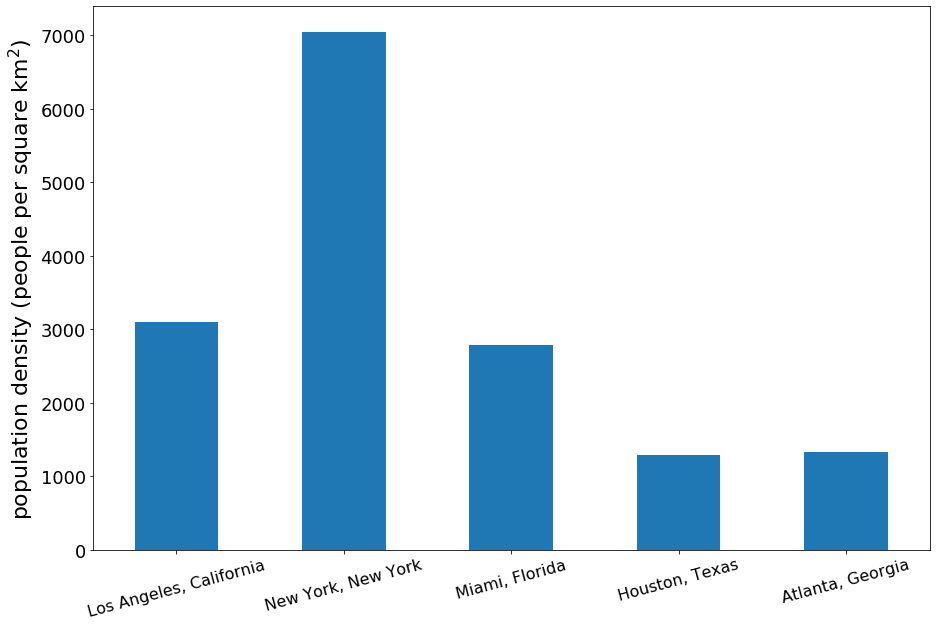

In [32]:
ax = df_bar_charts[['pop_density']].plot(kind='bar', title ="", figsize=(15, 10), legend=False, fontsize=18)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("population density (people per square km$^2$)", fontsize=22)
plt.xticks(rotation=15, fontsize=16)
#plt.show()
#plt.xticks(rotation=90)
plt.savefig('pop_densities.png')

## create bar chart for restaurant density (number of restaurants per square kilometer)

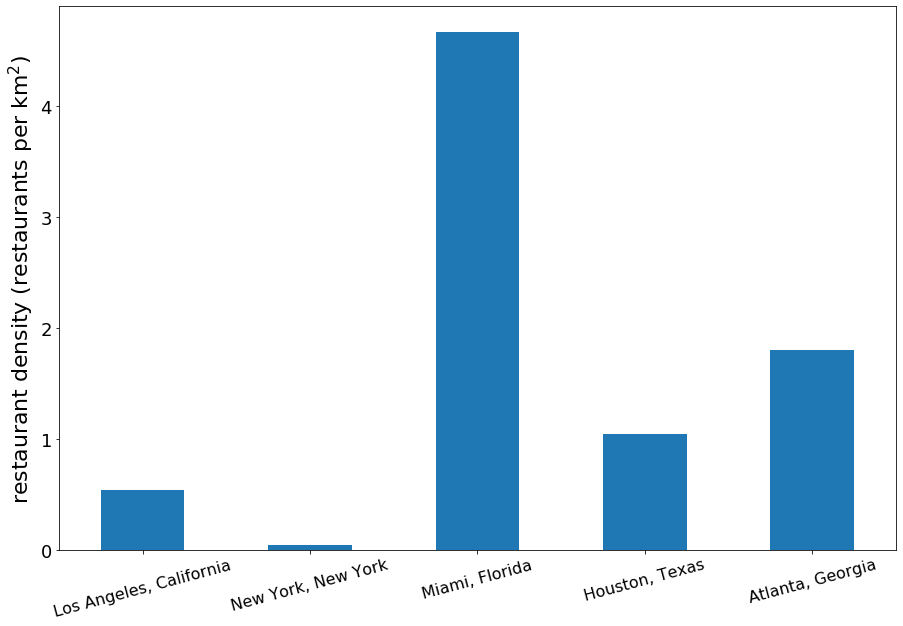

In [33]:
ax = df_bar_charts[['rest_density']].plot(kind='bar', title ="", figsize=(15, 10), legend=False, fontsize=18)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("restaurant density (restaurants per km$^2$)", fontsize=22)
plt.xticks(rotation=15, fontsize=16)
#plt.show()
plt.savefig('rest_densities.png')

# ----------------------- CASE STUDY : Los Angeles, CA -----------------------

### Plot zip codes and restaurant venues on map

In [34]:
map_Los_Angeles_venues = folium.Map(location=[DATA[0]['latitude'], DATA[0]['longitude']], zoom_start=11)
    
for zip_code in DATA[0]['zip_codes_lat_lng']:
    
    label = '{}'.format(zip_code[0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [zip_code[2], zip_code[1]],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Los_Angeles_venues)
        
for lat, lng, venue in zip(DATA[0]['R_df']['venue_lat'], DATA[0]['R_df']['venue_lng'], DATA[0]['R_df']['venue_name']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1.5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1.0,
        parse_html=False).add_to(map_Los_Angeles_venues)
    
map_Los_Angeles_venues

In [35]:
venues_df = DATA[0]['R_df']
zip_codes_list = DATA[0]['zip_codes_lat_lng']
print(len(DATA[0]['zip_codes_lat_lng']))
venue_zip_count = pd.DataFrame(DATA[0]['R_df'])
#display(venue_zip_count)

venue_zip_count = venue_zip_count.groupby(['zip_code']).size().to_frame('count').reset_index()

N_bins = int(venue_zip_count.shape[0] * 0.10)
min_val = venue_zip_count.min(axis=0)['count']
max_val = venue_zip_count.max(axis=0)['count']
zip_count_list = venue_zip_count.to_numpy().tolist()

#display(venue_zip_count)

print(min_val, max_val, N_bins, venue_zip_count.shape[0])

62
1 30 5 52


In [40]:
def put_zip_codes_in_bins(N_bins, min_val, max_val, zip_count_list, venue_zip_count, zip_codes_list):
    """
    
    """
    bin_min = max(0.0, min_val - 1.0)
    bin_max = max_val
    spacing = (bin_max - bin_min) / N_bins
    bins = [idx*spacing for idx in range(0,N_bins+1)]
    venue_zip_count['bin'] = 0
    venue_zip_count['lng'] = 0.0
    venue_zip_count['lat'] = 0.0
    for zip_idx in range(0, len(zip_count_list)):
        for i in range(0, len(zip_codes_list)):
            if (zip_count_list[zip_idx][0] == int(zip_codes_list[i][0])):
                lng = float(zip_codes_list[i][1])
                lat = float(zip_codes_list[i][2])
        for bin_idx in range(0, len(bins)-1):
            if ((zip_count_list[zip_idx][1] > bins[bin_idx]) and 
                (zip_count_list[zip_idx][1] <= bins[bin_idx+1])):
                venue_zip_count.at[zip_idx, 'bin'] = bin_idx
                venue_zip_count.at[zip_idx, 'lng'] = lng
                venue_zip_count.at[zip_idx, 'lat'] = lat
    return bins

In [41]:
bins = put_zip_codes_in_bins(N_bins, min_val, max_val, zip_count_list, venue_zip_count, zip_codes_list)

## Creates folium map showing restaurant locations and zip codes colored according to restaurant count frequency bin

In [42]:
map_clusters = folium.Map(location=[DATA[0]['latitude'], DATA[0]['longitude']], zoom_start=11)

colors = mpl.cm.rainbow(np.linspace(0, 1, N_bins))
colors_hex_codes = []
for i in range(0, N_bins):
    c = colors[i][:-1]
    c_hex = mpl.colors.rgb2hex(c)
    colors_hex_codes.append(c_hex)

markers_colors = []
for lat, lon, poi, cluster in zip(venue_zip_count['lat'], venue_zip_count['lng'], venue_zip_count['zip_code'], venue_zip_count['bin']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3.0,
        popup=label,
        color=colors_hex_codes[cluster-1],
        fill=True,
        fill_color=colors_hex_codes[cluster-1],
        fill_opacity=1.0).add_to(map_clusters)
       
for lat, lng, venue in zip(DATA[0]['R_df']['venue_lat'], DATA[0]['R_df']['venue_lng'], DATA[0]['R_df']['venue_name']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.45,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=1.0,
        parse_html=False).add_to(map_clusters)
    
map_clusters

In [43]:
print(bins)

[0.0, 6.0, 12.0, 18.0, 24.0, 30.0]


### red = cluster 1
### purple = cluster 2
### blue = cluster 3
### light green = cluster 4
### orange = cluster 5